# 基于深度学习的脑部肿瘤检测算法建模

In [1]:
#!pip install imutils keras opencv-python plotly scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
import numpy as np 
import cv2
import os
import shutil
import itertools
import imutils
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [4]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist 
             if os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6]
print(list(fonts))

# 显示中文,解决图中无法显示中文的问题
plt.rcParams['font.sans-serif']=['KaiTi']
 
# 设置显示中文后,负号显示受影响。解决坐标轴上乱码问题
plt.rcParams['axes.unicode_minus']=False

['Calibri', 'Nirmala UI', 'Segoe UI Historic', 'STFangsong', 'Nirmala UI', 'MingLiU-ExtB', 'STCaiyun', 'Calibri', 'Calibri', 'STHupo', 'FZShuTi', 'STXihei', 'LiSu', 'Malgun Gothic', 'Yu Gothic', 'STSong', 'Microsoft YaHei', 'SimSun-ExtB', 'Cambria', 'Yu Gothic', 'STKaiti', 'Microsoft YaHei', 'FZCuHeiSongS-B-GB', 'Malgun Gothic', 'Nirmala UI', 'Times New Roman', 'STXingkai', 'DengXian', 'SimSun', 'Malgun Gothic', 'STLiti', 'DengXian', 'Microsoft JhengHei', 'MS Gothic', 'STXinwei', 'Times New Roman', 'DengXian', 'Arial', 'Calibri', 'Microsoft YaHei', 'Segoe UI Emoji', 'SimHei', 'KaiTi', 'Calibri', 'Segoe UI Symbol', 'Microsoft JhengHei', 'FZYaoTi', 'STZhongsong', 'FangSong', 'Calibri', 'Yu Gothic', 'Gabriola', 'YouYuan', 'Microsoft JhengHei', 'Yu Gothic']


## 3. 数据读取与数据集扩充
利用图像的旋转、放大、剪切、对调等方式，实现对图像数据集的扩充。

In [5]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [6]:
data_dir = 'dataset'
class_map = {'无肿瘤': 0, '胶质瘤': 1, '垂体瘤': 2, '脑膜瘤': 3}
class_name_dict = {0: '无肿瘤', 1: '胶质瘤', 2: '垂体瘤', 3: '脑膜瘤'}

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            # shear_range=0.05,
            brightness_range=[0.5, 1.5],
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='categorical',
            target_size=(height, width),
            classes=class_map
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='categorical',
              target_size=(height, width),
              batch_size=batch_size,
            classes=class_map
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])

class_count = {}
for c in class_map:
    count = len(np.where(total_image==0)[0])
    class_count[c] = count
    
print('\n\n', class_count)

Found 5619 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.


 {'无肿瘤': 2000, '胶质瘤': 2000, '垂体瘤': 2000, '脑膜瘤': 2000}


### 样例数据可视化

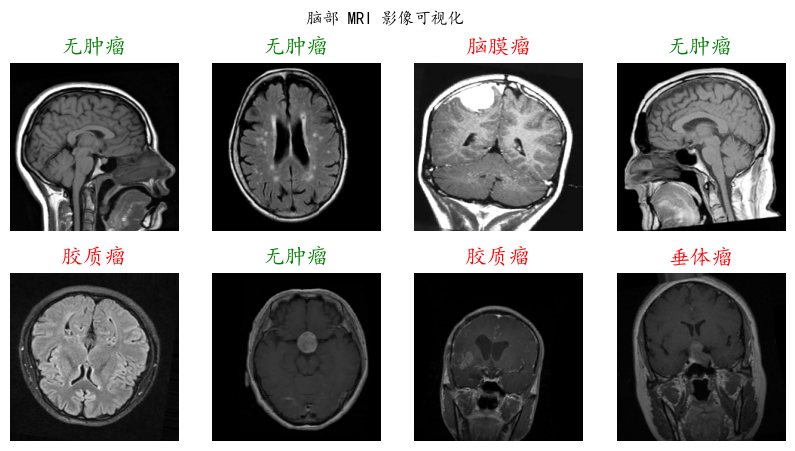

In [7]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle("脑部 MRI 影像可视化")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])

    index = np.argmax(labels[i])  # get image index
    class_name = class_name_dict[int(index)]
    if class_name == '无肿瘤':
        ax[i, j].set_title(class_name, color= 'green', fontsize= 16)
    else:
        ax[i, j].set_title(class_name, color= 'red', fontsize= 16)
        
    ax[i, j].axis('off')
plt.show()

## 4. 深度卷积神经网络模型构建

### 模型构建

In [8]:
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='./pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.Flatten())

model_vgg16.add(tf.keras.layers.Dense(4, activation='softmax'))

model_vgg16.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### 模型训练

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('save_models/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25


88/88 [==============================] - ETA: 0s - loss: 0.5933 - acc: 0.7854
Epoch 1: acc improved from -inf to 0.78537, saving model to save_models\vgg16_best.h5
88/88 [==============================] - 305s 3s/step - loss: 0.5933 - acc: 0.7854 - val_loss: 0.4132 - val_acc: 0.8504
Epoch 2/25


D:\python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



88/88 [==============================] - ETA: 0s - loss: 0.2729 - acc: 0.9030
Epoch 2: acc improved from 0.78537 to 0.90301, saving model to save_models\vgg16_best.h5
88/88 [==============================] - 307s 3s/step - loss: 0.2729 - acc: 0.9030 - val_loss: 0.3468 - val_acc: 0.8775
Epoch 3/25
23/88 [======>.......................] - ETA: 3:03 - loss: 0.2291 - acc: 0.9266

KeyboardInterrupt: 

#### 绘制模型训练的损失函数

In [ ]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('训练集和验证集的损失函数变化')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('训练集和验证集的准确率变化')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### 模型评估

In [ ]:
train_result = model_vgg16.evaluate(train_ds)
val_result = model_vgg16.evaluate(val_ds)

vgg16_eval_result = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
vgg16_eval_result

In [ ]:
ypred_val = model_vgg16.predict(val_ds[0][0])
ypred_val = np.argmax(ypred_val, axis=1)

true_val = np.argmax(val_ds[0][-1], axis=1)

print("混淆矩阵：")
print(confusion_matrix(true_val, ypred_val))
print("详细评估指标：")
print('\n',classification_report(ypred_val, true_val))

## 4.2 InceptionV3 Base Model
深度神经网络(Deep Neural Networks, DNN)或深度卷积网络中的Inception模块是由Google的Christian Szegedy等人提出，包括Inception-v1、Inception-v2、Inception-v3、Inception-v4及Inception-ResNet系列。

[经典神经网络 | 从Inception v1到Inception v4全解析](https://zhuanlan.zhihu.com/p/194382937)
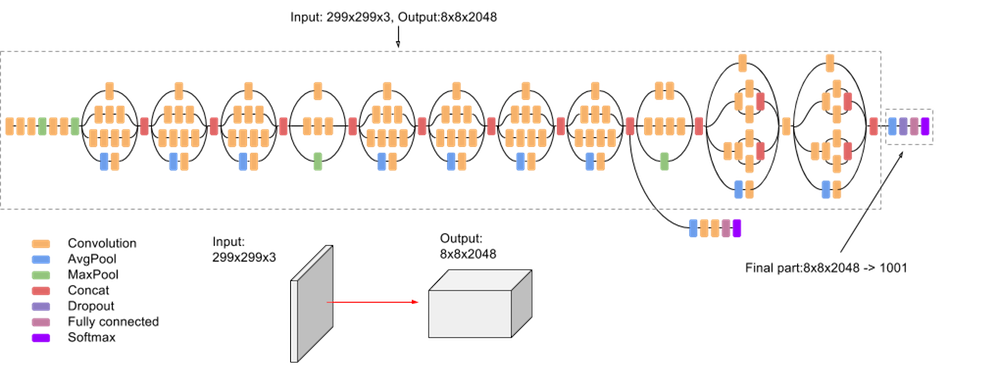

In [ ]:
%%time
tf.keras.backend.clear_session()

base_model = tf.keras.applications.InceptionV3(
    weights='./pretrained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())

model_inceptionv3.add(tf.keras.layers.Dense(4, activation='softmax'))

model_inceptionv3.compile(loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['acc']
)
model_inceptionv3.summary()

### 模型训练

In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('save_models/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

#### 绘制模型训练的损失函数

In [ ]:
# Define needed variables
tr_acc = history.history['acc']
tr_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('InceptionV3 模型训练集和验证集的损失函数变化')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('InceptionV3 模型训练集和验证集的准确率变化')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

inceptionv3_eval_result = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
inceptionv3_eval_result

In [ ]:
ypred_val = model_inceptionv3.predict(val_ds[0][0])
ypred_val = np.argmax(ypred_val, axis=1)

true_val = np.argmax(val_ds[0][-1], axis=1)

print("混淆矩阵：")
print(confusion_matrix(true_val, ypred_val))
print("详细评估指标：")
print('\n',classification_report(ypred_val, true_val))

## 结论

In [ ]:
vgg16_eval_result = vgg16_eval_result['Val'].to_dict()
inceptionv3_eval_result = inceptionv3_eval_result['Val'].to_dict()

In [ ]:
vgg16_eval_result

In [ ]:
inceptionv3_eval_result

In [ ]:
labels = ['LOSS', 'ACC']
vgg16_evals = [vgg16_eval_result['Loss'], vgg16_eval_result['Acc']]
inceptionv3_evals = [inceptionv3_eval_result['Loss'], inceptionv3_eval_result['Acc']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
rects1 = ax.bar(x - width/2, vgg16_evals, width, label='VGG16')
rects2 = ax.bar(x + width/2, inceptionv3_evals, width, label='Inception-V3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss/Acc')
ax.set_title('VGG16 与 Inception-V3 的脑部肿瘤检测性能对比')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
 
plt.show()